In [1]:
import pandas as pd
import numpy as np
import os
from ast import literal_eval

In [2]:
root_dir_data = "../data/parallel_measurements/"

# Read a recording

In [3]:
location = "TAU_Hertsi"
recording = "LOS1"
device = "3db_midas3" # Choose from: "dw3000", "tdsr", "3db_midas3"
filename = "unaligned_processed_data.csv"

In [4]:
df = pd.read_csv(os.path.join(root_dir_data, device, location, recording, filename), 
                 converters={"cir": literal_eval}) 
df.head(3)

,timestamp,true_distance,measured_distance,toa,cir,los_nlos_label
0,1.640004e+09,1.0,0.855144,110.0,"[5.0, 4.0, 2.0, 1.0, 6.0, 4.0, 3.0, 1.0, 0.0, ...",0
1,1.640004e+09,1.0,0.954072,111.0,"[3.0, 1.0, 2.0, 3.0, 5.0, 7.0, 5.0, 1.0, 3.0, ...",0
2,1.640004e+09,1.0,1.102464,112.0,"[4.0, 2.0, 3.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, ...",0


# Get CIRs recorded at the same location

In [5]:
# Get all the unique true distances from a recording
set_true_distances = list(set(list(df["true_distance"])))
print("All true distances: ", set_true_distances)

# Select measurements corresponding to one true distance
selected_true_distance = set_true_distances[0]
df_sel = df.loc[np.abs(df["true_distance"] - selected_true_distance) < 0.005]
display(df_sel.head(3))

# Get all the CIRs as a numpy array
cirs = [c for c in df_sel["cir"]] # Transform first to a list of lists
cirs = np.array(cirs) # Now we can convert it to a numpy array

All true distances:  [1.0, 2.6, 3.4000000000000004, 4.2, 1.8, 5.0, 5.800000000000001]


,timestamp,true_distance,measured_distance,toa,cir,los_nlos_label
0,1.640004e+09,1.0,0.855144,110.0,"[5.0, 4.0, 2.0, 1.0, 6.0, 4.0, 3.0, 1.0, 0.0, ...",0
1,1.640004e+09,1.0,0.954072,111.0,"[3.0, 1.0, 2.0, 3.0, 5.0, 7.0, 5.0, 1.0, 3.0, ...",0
2,1.640004e+09,1.0,1.102464,112.0,"[4.0, 2.0, 3.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, ...",0


# Plot CIRs

In [6]:
# Imports for plots
from common.custom_colors import mycolor
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 18})

# Function to plot stacked CIRs
def plot_cir_stack(cirs, toas, errs, figsize=(10, 6)):    
    my_cmap = clr.LinearSegmentedColormap.from_list('mypalette', ['#ffffff', mycolor["neutral1"]], N=256)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(
        cirs, 
        cmap=my_cmap, vmin=np.min(cirs), vmax=np.max(cirs), aspect="auto")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.formatter.set_powerlimits((0, 4))
    cbar.update_ticks()
    cbar.set_label('CIR amplitude')

    # Display TOAs
    y = np.arange(0, cirs.shape[0], 1)
    
    ax.scatter(toas, y, marker="o", c=errs, ec="black", cmap="Reds", label="TOA")

    # Add colorbar for distance errors
    cax = divider.append_axes('right', size='5%', pad=1)
    norm = clr.Normalize(vmin=np.min(errs*100), vmax=np.max(errs*100))
    sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    cbar.update_ticks()
    cbar.set_label('Distance error [cm]')

    ax.set_ylabel("Idx. of CIR meas.")
    ax.set_xlabel("t [ns]")
    
    return fig, ax

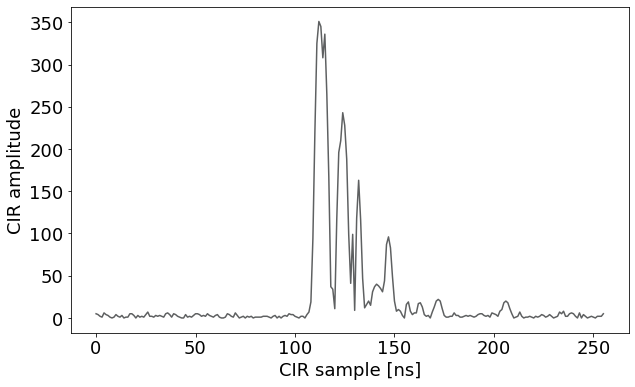

In [7]:
# Plot a single CIR
fig, ax = plt.subplots(figsize=[10, 6])
ax.plot(cirs[0, :], color=mycolor["neutral2"])
ax.set_xlabel("CIR sample [ns]")
ax.set_ylabel("CIR amplitude")
plt.show()

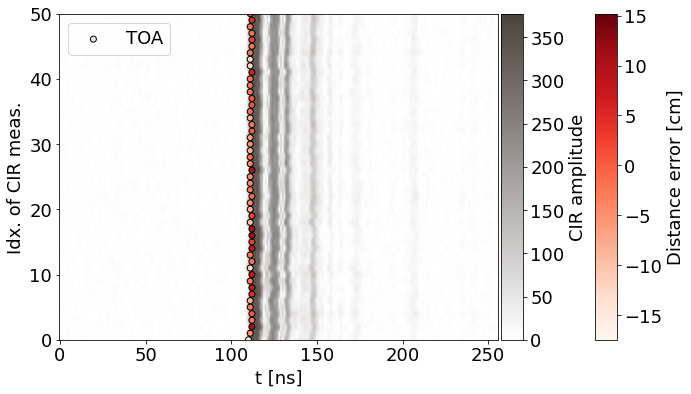

In [8]:
# Plot stacked CIRs
errs = np.array(df_sel["measured_distance"]) - np.array(df_sel["true_distance"])
fig, ax = plot_cir_stack(cirs=cirs, 
                         toas=np.array(df_sel["toa"]),
                         errs=errs,)
ax.set_ylim((0, 50)) # For better visibility
ax.legend(loc="upper left")
plt.show()